# AI Takeoff Trajectory Simulation

Simulating the Jones model with automation:

$$S'(t) = \frac{k}{f^f (1-f)^{(1-f)}} L^{1-f} C^{f} S^{1 - \beta}$$

$$f(t) = \sigma(v(\log C(t)S(t) - \log E_{hac}))$$

## Key Parameters
- **S**: Software level (training + inference efficiency)
- **C(t)S(t)**: Effective compute of the best AI
- **f**: Fraction of automatable tasks (sigmoid in log of effective compute)
- **R(t)**: Research production = $\frac{1}{f^f (1-f)^{(1-f)}} L^{1-f} C^{f}$
- **β**: Difficulty exponent for software improvement
- **v**: Automation velocity (effective compute increases by e^(1/v) to go from 50% to 73% automation)
- **E_hac**: Effective compute level of the half-automated coder

## Constraints (Jan 2026)
- Rate of change of S: 5x/year on log scale
- 1/v: triangular [1.5, 4.2]
- f: triangular [0.25, 0.5]
- β: triangular [0.3, 1]
- L doubles annually 2026-2029, then increases 10%/year
- C grows 2.6x annually 2026-2029, then growth rate linearly decreases from 2x/year to 1.25x/year between 2030 and 2058

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import expit  # sigmoid function
from ipywidgets import interact, FloatSlider, IntSlider, fixed
import ipywidgets as widgets
from IPython.display import display

%matplotlib inline

# Global configuration
YEAR_START = 2026  # Start year of simulation
YEAR_CUTOFF = 2070  # Cutoff year for "not reached" trajectories
YEAR_NOT_REACHED = 2100  # Value assigned to trajectories that don't reach 99% by cutoff
YEAR_PLOT_END = 2055  # End year for plot x-axes
T_END = YEAR_CUTOFF - YEAR_START  # Simulation duration in years

## Parameter Sampling

All variables triangularly and independently distributed.

In [ ]:
def triangular_sample(low, high):
    """Sample from triangular distribution with mode at midpoint."""
    mode = (low + high) / 2
    return np.random.triangular(low, mode, high)

def sigmoid(x):
    """Sigmoid function."""
    return expit(x)

def f_automation(C, S, v, E_hac):
    """Fraction of automatable tasks as sigmoid in log of effective compute C*S."""
    return sigmoid(v * (np.log(C * S) - np.log(E_hac)))

def ff_prefactor(f):
    """
    Compute 1 / (f^f * (1-f)^(1-f)).
    Handles edge cases: 0^0 = 1 by convention.
    """
    if np.isscalar(f):
        if f <= 0 or f >= 1:
            return 1.0
        return 1.0 / (f**f * (1 - f)**(1 - f))
    else:
        f = np.asarray(f, dtype=float)
        result = np.ones_like(f)
        mask = (f > 0) & (f < 1)
        fm = f[mask]
        result[mask] = 1.0 / (fm**fm * (1 - fm)**(1 - fm))
        return result

def sample_parameters():
    """
    Sample parameters satisfying the constraints.
    
    New equation: S' = k / (f^f (1-f)^(1-f)) * L^(1-f) * C^f * S^(1-beta)
    
    Returns:
        dict with all parameters
    """
    # Sample constrained parameters
    # 1/v is triangular [1.5, 4.2]
    one_over_v = triangular_sample(1.5, 4.2)
    v = 1.0 / one_over_v
    f_2026 = triangular_sample(0.25, 0.5)  # f at Jan 2026
    beta = triangular_sample(0.3, 1.0)  # β
    
    # Set L_2026 = 1 for normalization
    L_2026 = 1.0
    
    # Set S_2026 = 1 and C_2026 = 1 as reference points
    S_2026 = 1.0
    C_2026 = 1.0
    
    # From f_2026 = sigmoid(v * (log(C_2026 * S_2026) - log(E_hac)))
    # We can solve for E_hac:
    # logit(f_2026) = v * (log(C_2026 * S_2026) - log(E_hac))
    # log(E_hac) = log(C_2026 * S_2026) - logit(f_2026) / v
    from scipy.special import logit
    log_E_hac = np.log(C_2026 * S_2026) - logit(f_2026) / v
    E_hac = np.exp(log_E_hac)
    
    # Rate of change of S at Jan 2026 is 5x/year on log scale
    # d(log S)/dt = log(5) at t=0 (Jan 2026)
    # S'/S = log(5)
    # So S' = S * log(5) at Jan 2026
    # 
    # We need to find a scaling factor k such that the ODE gives this growth rate.
    # The ODE is: S' = k / (f^f (1-f)^(1-f)) * L^(1-f) * C^f * S^(1-beta)
    # At t=0: S' = k * ff_prefactor(f_2026) * L_2026^(1-f_2026) * C_2026^f_2026 * S_2026^(1-beta)
    # We want S' = S_2026 * log(5), so:
    # k = S_2026 * log(5) / (ff_prefactor(f_2026) * L_2026^(1-f_2026) * C_2026^f_2026 * S_2026^(1-beta))
    dlogS_dt_2026 = np.log(5)  # 5x/year means d(log S)/dt = log(5)
    dS_dt_2026 = S_2026 * dlogS_dt_2026
    
    prefactor = ff_prefactor(f_2026)
    labor_term = L_2026 ** (1 - f_2026)
    C_term = C_2026 ** f_2026
    S_term = S_2026 ** (1 - beta)
    
    k = dS_dt_2026 / (prefactor * labor_term * C_term * S_term)
    
    return {
        'beta': beta,
        'v': v,
        'one_over_v': one_over_v,
        'L_2026': L_2026,
        'C_2026': C_2026,
        'S_2026': S_2026,
        'E_hac': E_hac,
        'f_2026': f_2026,
        'k': k  # scaling factor for ODE
    }

# Test sampling
np.random.seed(42)
params = sample_parameters()
print("Sample parameters:")
for key, val in params.items():
    print(f"  {key}: {val:.4f}")
print(f"\nVerification:")
C_2026 = params['C_2026']
S_2026 = params['S_2026']
print(f"  f(C_2026*S_2026) = {f_automation(C_2026, S_2026, params['v'], params['E_hac']):.4f} (should be ~{params['f_2026']:.4f})")
print(f"  1/v = {params['one_over_v']:.4f} (should be in [1.5, 4.2])")

<cell_type>markdown</cell_type>## Compute and Labor Schedule

- L doubles annually from 2026-2029, then increases 10%/year
- C grows 2.6x annually from 2026-2029, then growth rate linearly decreases from 2x/year to 1.25x/year between 2030 and 2058

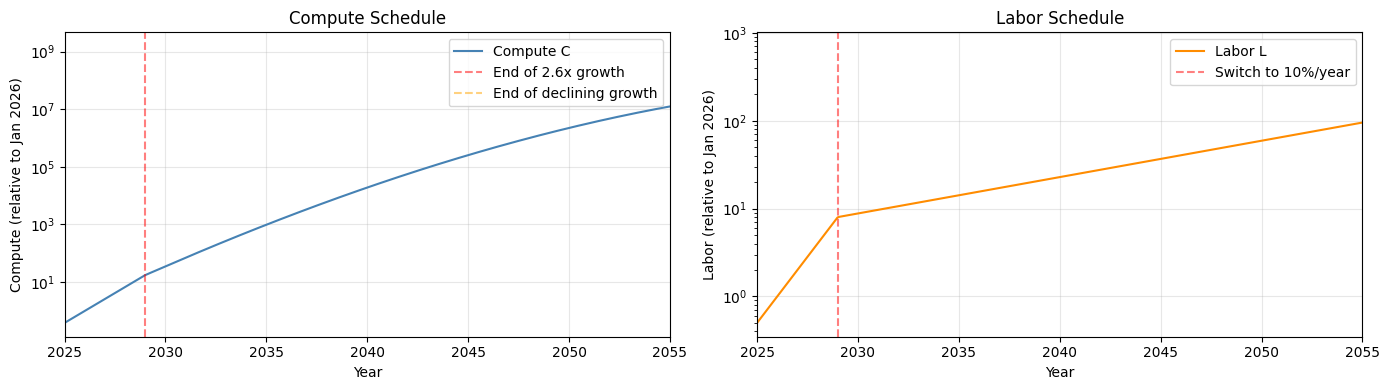

Compute growth factors:
  2026-2029: 2.6x/year
  2030: 2x/year
  2044 (midpoint): ~1.625x/year
  2058+: 1.25x/year

Labor growth:
  2026-2029: 2x/year
  2029+: 1.10x/year


In [3]:
# Precompute compute and labor schedules at integer years, then interpolate

def _build_compute_schedule_cache(C_2026, t_max=100):
    """Build cache of compute values at integer years."""
    cache = {0: C_2026}
    
    # 2026-2029 (t=0 to t=3): 2.6x annually
    for t in range(1, 4):
        cache[t] = cache[t-1] * 2.6
    
    # t=3 to t=4: 2x growth (transition year)
    cache[4] = cache[3] * 2.0
    
    # t=4 to t=32 (2030-2058): growth rate linearly decreases from 2x to 1.25x
    for t in range(5, 33):
        # rate at year t-1 to t: linear interpolation
        # At t=4: rate=2, at t=32: rate=1.25
        rate = 2.0 - 0.75 * (t - 1 - 4) / 28  # rate for the year ending at t
        cache[t] = cache[t-1] * rate
    
    # t=32+ (2058+): constant 1.25x growth
    for t in range(33, t_max + 1):
        cache[t] = cache[t-1] * 1.25
    
    return cache

def _build_labor_schedule_cache(L_2026, t_max=100):
    """Build cache of labor values at integer years."""
    cache = {0: L_2026}
    
    # 2026-2029 (t=0 to t=3): double annually
    for t in range(1, 4):
        cache[t] = cache[t-1] * 2.0
    
    # t=3+ (2029+): 10%/year growth
    for t in range(4, t_max + 1):
        cache[t] = cache[t-1] * 1.10
    
    return cache

# Build caches with C_2026=1 and L_2026=1 (we'll scale later)
_C_CACHE = _build_compute_schedule_cache(1.0)
_L_CACHE = _build_labor_schedule_cache(1.0)

def compute_schedule(t, C_2026):
    """
    Compute as a function of time using cached values with geometric interpolation.
    t=0 is Jan 2026, t=1 is Jan 2027, etc.
    """
    if t < 0:
        # Before 2026: extrapolate backwards (2.6x/year)
        return C_2026 * (2.6 ** t)
    
    t_floor = int(t)
    t_ceil = t_floor + 1
    frac = t - t_floor
    
    # Get cached values (scaled by C_2026)
    C_floor = _C_CACHE.get(t_floor, _C_CACHE[max(_C_CACHE.keys())]) * C_2026
    C_ceil = _C_CACHE.get(t_ceil, _C_CACHE[max(_C_CACHE.keys())] * 1.25) * C_2026
    
    # Geometric interpolation: C(t) = C_floor * (C_ceil/C_floor)^frac
    if frac == 0:
        return C_floor
    return C_floor * (C_ceil / C_floor) ** frac

def labor_schedule(t, L_2026):
    """
    Labor as a function of time using cached values with geometric interpolation.
    t=0 is Jan 2026, t=1 is Jan 2027, etc.
    """
    if t < 0:
        # Before 2026: extrapolate backwards (2x/year)
        return L_2026 * (2.0 ** t)
    
    t_floor = int(t)
    t_ceil = t_floor + 1
    frac = t - t_floor
    
    # Get cached values (scaled by L_2026)
    L_floor = _L_CACHE.get(t_floor, _L_CACHE[max(_L_CACHE.keys())]) * L_2026
    L_ceil = _L_CACHE.get(t_ceil, _L_CACHE[max(_L_CACHE.keys())] * 1.10) * L_2026
    
    # Geometric interpolation: L(t) = L_floor * (L_ceil/L_floor)^frac
    if frac == 0:
        return L_floor
    return L_floor * (L_ceil / L_floor) ** frac

# Plot compute and labor schedules
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

t_test = np.linspace(-1, 50, 500)
C_test = [compute_schedule(t, 1.0) for t in t_test]
L_test = [labor_schedule(t, 1.0) for t in t_test]

ax1.plot(t_test + YEAR_START, C_test, label='Compute C', color='steelblue')
ax1.set_yscale('log')
ax1.set_xlabel('Year')
ax1.set_ylabel('Compute (relative to Jan 2026)')
ax1.set_title('Compute Schedule')
ax1.axvline(2029, color='red', linestyle='--', alpha=0.5, label='End of 2.6x growth')
ax1.axvline(2058, color='orange', linestyle='--', alpha=0.5, label='End of declining growth')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(2025, YEAR_PLOT_END)

ax2.plot(t_test + YEAR_START, L_test, label='Labor L', color='darkorange')
ax2.set_yscale('log')
ax2.set_xlabel('Year')
ax2.set_ylabel('Labor (relative to Jan 2026)')
ax2.set_title('Labor Schedule')
ax2.axvline(2029, color='red', linestyle='--', alpha=0.5, label='Switch to 10%/year')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(2025, YEAR_PLOT_END)

plt.tight_layout()
plt.show()

# Print some reference values
print(f"Compute growth factors:")
print(f"  2026-2029: 2.6x/year")
print(f"  2030: 2x/year")
print(f"  2044 (midpoint): ~1.625x/year")
print(f"  2058+: 1.25x/year")
print(f"\nLabor growth:")
print(f"  2026-2029: 2x/year")
print(f"  2029+: 1.10x/year")

## Solving the ODE

Integrate the differential equation forward in time.

In [ ]:
def jones_model_derivative(t, S, beta, v, k, L_2026, C_2026, E_hac):
    """
    Compute dS/dt according to new Jones model with automation.
    
    S'(t) = k / (f^f * (1-f)^(1-f)) * L^(1-f) * C^f * S^(1-β)
    f(t) = σ(v * (log(C*S) - log(E_hac)))
    """
    if S <= 0:
        return 0
    
    C = compute_schedule(t, C_2026)
    L = labor_schedule(t, L_2026)
    f = f_automation(C, S, v, E_hac)
    
    # Avoid division by zero as f approaches 1
    if f >= 0.999999:
        f = 0.999999
    if f <= 0.000001:
        f = 0.000001
    
    prefactor = ff_prefactor(f)
    dS_dt = k * prefactor * (L ** (1 - f)) * (C ** f) * (S ** (1 - beta))
    
    return dS_dt

def simulate_trajectory(params, t_start=-0.5, t_end=6, max_S=1e12):
    """
    Simulate S(t) from t_start to t_end (relative to Jan 2026).
    Trajectories are truncated once f reaches 99.9999%.
    
    Returns:
        t_array, S_array, f_array, R_array, serial_ratio_array,
        parallel_ratio_array, reached_99 (time when f >= 0.99, or None)
    """
    beta = params['beta']
    v = params['v']
    k = params['k']
    L_2026 = params['L_2026']
    C_2026 = params['C_2026']
    E_hac = params['E_hac']
    S_2026 = params['S_2026']
    
    # Initial condition: extrapolate S backwards from 2026
    # Use the growth rate to estimate S at t_start
    dlogS_dt = np.log(5)  # 5x/year
    S_init = S_2026 * np.exp(dlogS_dt * t_start)
    
    # Event to detect 99% automation
    def automation_99_event(t, S, *args):
        C = compute_schedule(t, C_2026)
        f = f_automation(C, S[0], v, E_hac)
        return f - 0.99
    automation_99_event.terminal = False
    automation_99_event.direction = 1
    
    # Event to detect very high S (numerical stability)
    def max_S_event(t, S, *args):
        return S[0] - max_S
    max_S_event.terminal = True
    max_S_event.direction = 1
    
    try:
        sol = solve_ivp(
            jones_model_derivative,
            (t_start, t_end),
            [S_init],
            args=(beta, v, k, L_2026, C_2026, E_hac),
            dense_output=True,
            events=[automation_99_event, max_S_event],
            max_step=0.1,
            atol=1e-8
        )
        
        # Get dense output
        t_dense = np.linspace(t_start, sol.t[-1], 500)
        S_dense = sol.sol(t_dense)[0]
        C_dense = np.array([compute_schedule(t, C_2026) for t in t_dense])
        L_dense = np.array([labor_schedule(t, L_2026) for t in t_dense])
        f_dense = np.array([f_automation(C_dense[i], S_dense[i], v, E_hac) for i in range(len(t_dense))])
        
        # Truncate once f reaches the cap
        cap_mask = f_dense >= 0.999999
        if np.any(cap_mask):
            cap_idx = np.argmax(cap_mask) + 1  # include the first point at cap
            t_dense = t_dense[:cap_idx]
            S_dense = S_dense[:cap_idx]
            C_dense = C_dense[:cap_idx]
            L_dense = L_dense[:cap_idx]
            f_dense = f_dense[:cap_idx]
        
        # Compute R(t) = (1/(f^f * (1-f)^(1-f))) * L^(1-f) * C^f
        f_capped = np.minimum(np.maximum(f_dense, 0.000001), 0.999999)
        prefactor_arr = ff_prefactor(f_capped)
        R_dense = prefactor_arr * (L_dense ** (1 - f_capped)) * (C_dense ** f_capped)
        
        # Serial compute:labor ratio C^f / L^(1-f) (with dynamic exponents)
        labor_term = L_dense ** (1 - f_capped)
        compute_term = C_dense ** f_capped
        serial_ratio = compute_term / labor_term
        
        # Parallel compute:labor ratio C^f / L^(1-f) (same as serial in this model)
        parallel_ratio = compute_term / labor_term
        
        # Normalize both to 2026 value (t=0)
        idx_2026 = np.argmin(np.abs(t_dense - 0))
        serial_ratio_normalized = serial_ratio / serial_ratio[idx_2026]
        parallel_ratio_normalized = parallel_ratio / parallel_ratio[idx_2026]
        
        # Check for 99% automation time
        reached_99 = None
        if sol.t_events[0] is not None and len(sol.t_events[0]) > 0:
            reached_99 = sol.t_events[0][0] + YEAR_START  # Convert to year
        
        return t_dense, S_dense, f_dense, R_dense, serial_ratio_normalized, parallel_ratio_normalized, reached_99
        
    except Exception as e:
        print(f"Integration error: {e}")
        return None, None, None, None, None, None, None

# Test with one trajectory
np.random.seed(42)
params = sample_parameters()
t_arr, S_arr, f_arr, R_arr, serial_ratio_arr, parallel_ratio_arr, time_99 = simulate_trajectory(params, t_start=0, t_end=20)

if t_arr is not None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Top left: S(t)
    axes[0, 0].plot(t_arr + YEAR_START, S_arr)
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Software Level S')
    axes[0, 0].set_yscale('log')
    axes[0, 0].set_title('Software Efficiency')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlim(YEAR_START, YEAR_PLOT_END)
    
    # Top right: Parallel compute:labor ratio
    axes[0, 1].plot(t_arr + YEAR_START, parallel_ratio_arr)
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Compute:Labor Ratio (2026=1)')
    axes[0, 1].set_yscale('log')
    axes[0, 1].set_title('Compute:Labor Ratio $C^f / L^{1-f}$ (normalized)')
    axes[0, 1].axhline(1, color='gray', linestyle='--', alpha=0.5)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlim(YEAR_START, YEAR_PLOT_END)
    
    # Bottom left: R(t)
    axes[1, 0].plot(t_arr + YEAR_START, R_arr)
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Research Production R(t)')
    axes[1, 0].set_yscale('log')
    axes[1, 0].set_title('Research Production')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim(YEAR_START, YEAR_PLOT_END)
    
    # Bottom right: Serial compute:labor ratio
    axes[1, 1].plot(t_arr + YEAR_START, serial_ratio_arr)
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Compute:Labor Ratio (2026=1)')
    axes[1, 1].set_yscale('log')
    axes[1, 1].set_title('Compute:Labor Ratio $C^f / L^{1-f}$ (normalized)')
    axes[1, 1].axhline(1, color='gray', linestyle='--', alpha=0.5)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlim(YEAR_START, YEAR_PLOT_END)
    
    plt.tight_layout()
    plt.show()
    
    # Separate automation trajectory plot
    fig2, ax_f = plt.subplots(figsize=(8, 5))
    ax_f.plot(t_arr + YEAR_START, f_arr, linewidth=2, color='steelblue')
    ax_f.axhline(0.99, color='red', linestyle='--', alpha=0.5, label='99% automation')
    if time_99:
        ax_f.axvline(time_99, color='green', linestyle='--', alpha=0.5, label=f'99% at {time_99:.2f}')
    ax_f.set_xlabel('Year')
    ax_f.set_ylabel('Automation fraction f')
    ax_f.set_title('Automation Trajectory')
    ax_f.set_yscale('logit')
    ax_f.set_ylim(0.1, 0.999)
    ax_f.axhline(0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    ax_f.axhline(0.9, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    ax_f.axhline(0.98, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    ax_f.legend()
    ax_f.grid(True, alpha=0.3)
    ax_f.set_xlim(YEAR_START, YEAR_PLOT_END)
    plt.tight_layout()
    plt.show()
    
    print(f"\nParameters: β={params['beta']:.3f}, v={params['v']:.3f}")
    print(f"Time to 99% automation: {time_99:.2f}" if time_99 else "Did not reach 99% automation")

## Output 1: 40 Trajectories of S and f

In [5]:
def generate_trajectories(n_trajectories=40, t_start=0, t_end=T_END, seed=42):
    """
    Generate multiple random trajectories.
    """
    np.random.seed(seed)
    trajectories = []
    params_list = []
    times_to_99 = []
    
    for i in range(n_trajectories):
        params = sample_parameters()
        result = simulate_trajectory(params, t_start=t_start, t_end=t_end)
        t_arr, S_arr, f_arr, R_arr, serial_ratio_arr, parallel_ratio_arr, time_99 = result
        
        if t_arr is not None:
            trajectories.append((t_arr, S_arr, f_arr, R_arr, serial_ratio_arr, parallel_ratio_arr))
            params_list.append(params)
            # If didn't reach 99% by cutoff, set to YEAR_NOT_REACHED
            if time_99 is None:
                time_99 = YEAR_NOT_REACHED
            times_to_99.append(time_99)
    
    return trajectories, params_list, times_to_99

# Generate 40 trajectories
print(f"Generating 40 trajectories (until {YEAR_CUTOFF})...")
trajectories, params_list, times_to_99 = generate_trajectories(n_trajectories=40, t_start=0, t_end=T_END)
print(f"Successfully generated {len(trajectories)} trajectories")

# Count how many reached 99% automation by cutoff
n_reached_99 = sum(1 for t in times_to_99 if t < YEAR_NOT_REACHED)
print(f"Trajectories reaching 99% automation by {YEAR_CUTOFF}: {n_reached_99}/{len(trajectories)}")

Generating 40 trajectories (until 2070)...


Successfully generated 40 trajectories
Trajectories reaching 99% automation by 2070: 40/40


In [ ]:
import os
os.makedirs('new_figures', exist_ok=True)

# Plot 40 trajectories: 4-panel plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.subplots_adjust(left=0.08, right=0.85, top=0.92, bottom=0.07, hspace=0.3, wspace=0.3)
fig.suptitle('Other Metrics Over Time (40 sampled trajectories)', fontsize=16)

# Color by time to 99% automation (cap display at cutoff for coloring)
times_for_color = [min(t, YEAR_CUTOFF) for t in times_to_99]
t_min, t_max = min(times_for_color), max(times_for_color)

cmap = plt.cm.viridis

for i, (t_arr, S_arr, f_arr, R_arr, serial_ratio_arr, parallel_ratio_arr) in enumerate(trajectories):
    if times_to_99[i] < YEAR_NOT_REACHED:
        color = cmap((times_for_color[i] - t_min) / (t_max - t_min + 0.01))
        alpha = 0.7
    else:
        color = 'gray'
        alpha = 0.4
    
    # Top left: S(t)
    axes[0, 0].plot(t_arr + YEAR_START, S_arr, color=color, alpha=alpha, linewidth=1)
    
    # Top right: Compute:labor ratio
    axes[0, 1].plot(t_arr + YEAR_START, parallel_ratio_arr, color=color, alpha=alpha, linewidth=1)
    
    # Bottom left: R(t)
    axes[1, 0].plot(t_arr + YEAR_START, R_arr, color=color, alpha=alpha, linewidth=1)
    
    # Bottom right: Compute:labor ratio
    axes[1, 1].plot(t_arr + YEAR_START, serial_ratio_arr, color=color, alpha=alpha, linewidth=1)

# Top left: S(t)
axes[0, 0].set_xlabel('Year', fontsize=12)
axes[0, 0].set_ylabel('Algorithmic Efficiency', fontsize=12)
axes[0, 0].set_yscale('log')
axes[0, 0].set_title('Algorithmic Efficiency S', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(YEAR_START, YEAR_PLOT_END)

# Top right: Compute:labor ratio
axes[0, 1].set_xlabel('Year', fontsize=12)
axes[0, 1].set_ylabel('Compute:Labor Ratio (2026=1)', fontsize=12)
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Compute:Labor Ratio $C^f / L^{1-f}$', fontsize=14)
axes[0, 1].axhline(1, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(YEAR_START, YEAR_PLOT_END)
axes[0, 1].text(0.97, 0.92, 'More compute', transform=axes[0, 1].transAxes,
                fontsize=10, ha='right', va='top', color='gray', style='italic')
axes[0, 1].text(0.97, 0.08, 'More labor', transform=axes[0, 1].transAxes,
                fontsize=10, ha='right', va='bottom', color='gray', style='italic')

# Bottom left: R(t)
axes[1, 0].set_xlabel('Year', fontsize=12)
axes[1, 0].set_ylabel('Research Production', fontsize=12)
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('Research Production R(t)', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(YEAR_START, YEAR_PLOT_END)

# Bottom right: Compute:labor ratio
axes[1, 1].set_xlabel('Year', fontsize=12)
axes[1, 1].set_ylabel('Compute:Labor Ratio (2026=1)', fontsize=12)
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Compute:Labor Ratio $C^f / L^{1-f}$', fontsize=14)
axes[1, 1].axhline(1, color='gray', linestyle='--', alpha=0.5)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(YEAR_START, YEAR_PLOT_END)
axes[1, 1].text(0.97, 0.92, 'More compute', transform=axes[1, 1].transAxes,
                fontsize=10, ha='right', va='top', color='gray', style='italic')
axes[1, 1].text(0.97, 0.08, 'More labor', transform=axes[1, 1].transAxes,
                fontsize=10, ha='right', va='bottom', color='gray', style='italic')

# Add colorbar in dedicated space on the right
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=t_min, vmax=t_max))
sm.set_array([])
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(sm, cax=cbar_ax, label='Year of 99% automation')

fig.savefig('new_figures/trajectories.png', dpi=150, bbox_inches='tight')
plt.show()

n_not_reached = sum(1 for t in times_to_99 if t >= YEAR_NOT_REACHED)
print(f"Gray lines: {n_not_reached} trajectories that don't reach 99% by {YEAR_CUTOFF}")
print(f"Saved to new_figures/trajectories.png")

# Generate 500 trajectories for histogram
print(f"Generating 500 trajectories for histogram...")
_, _, times_to_99_hist = generate_trajectories(n_trajectories=500, t_start=0, t_end=T_END, seed=123)
median_99 = np.median(times_to_99_hist)

# Automation trajectories plot with histogram bottom panel
fig2, (ax_f, ax_hist) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[3, 1],
                                      gridspec_kw={'hspace': 0.05})

for i, (t_arr, S_arr, f_arr, R_arr, serial_ratio_arr, parallel_ratio_arr) in enumerate(trajectories):
    if times_to_99[i] < YEAR_NOT_REACHED:
        color = cmap((times_for_color[i] - t_min) / (t_max - t_min + 0.01))
        alpha = 0.7
    else:
        color = 'gray'
        alpha = 0.4
    ax_f.plot(t_arr + YEAR_START, f_arr, color=color, alpha=alpha, linewidth=1)

ax_f.set_ylabel('Automation fraction f', fontsize=12)
ax_f.set_title('Time Until 99% AI R&D Automation (40 sampled trajectories)', fontsize=14)
ax_f.set_yscale('logit')
ax_f.set_ylim(0.1, 0.999)
ax_f.axhline(0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
ax_f.axhline(0.9, color='gray', linestyle=':', alpha=0.5, linewidth=1)
ax_f.axhline(0.98, color='gray', linestyle=':', alpha=0.5, linewidth=1)
ax_f.axhline(0.99, color='red', linestyle='--', alpha=0.7, linewidth=2, label='99% automation')
ax_f.legend(fontsize=11)
ax_f.grid(True, alpha=0.3)
ax_f.set_xlim(YEAR_START, YEAR_PLOT_END)
ax_f.tick_params(labelbottom=False)  # hide x tick labels on top panel

# Median label on top panel
ax_f.text(0.97, 0.05, f'Median: {median_99:.1f}', transform=ax_f.transAxes,
          fontsize=12, ha='right', va='bottom',
          bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))

# Histogram bottom panel (500 trajectories)
ax_hist.hist(times_to_99_hist, bins=np.arange(2027, YEAR_PLOT_END + 0.5, 0.5),
             edgecolor='black', linewidth=0.5, alpha=0.7, color='steelblue')
ax_hist.axvline(median_99, color='red', linestyle='--', linewidth=2,
                label=f'Median: {median_99:.1f}')
ax_hist.set_xlabel('Year', fontsize=12)
ax_hist.set_ylabel('Count', fontsize=12)
ax_hist.legend(fontsize=10)
ax_hist.grid(True, alpha=0.3)
ax_hist.set_xlim(YEAR_START, YEAR_PLOT_END)

plt.tight_layout()
fig2.savefig('new_figures/automation.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved to new_figures/automation.png")

## Output 2: Distribution of Time to 99% Automation

In [7]:
# Generate more trajectories for better statistics
print(f"Generating 500 trajectories for distribution analysis (until {YEAR_CUTOFF})...")
trajectories_large, params_large, times_to_99_large = generate_trajectories(
    n_trajectories=500, t_start=0, t_end=T_END, seed=123
)
print(f"Successfully generated {len(trajectories_large)} trajectories")

n_reached = sum(1 for t in times_to_99_large if t < YEAR_NOT_REACHED)
print(f"Trajectories reaching 99% automation by {YEAR_CUTOFF}: {n_reached}/{len(times_to_99_large)} ({100*n_reached/len(times_to_99_large):.1f}%)")

Generating 500 trajectories for distribution analysis (until 2070)...


Successfully generated 500 trajectories
Trajectories reaching 99% automation by 2070: 500/500 (100.0%)


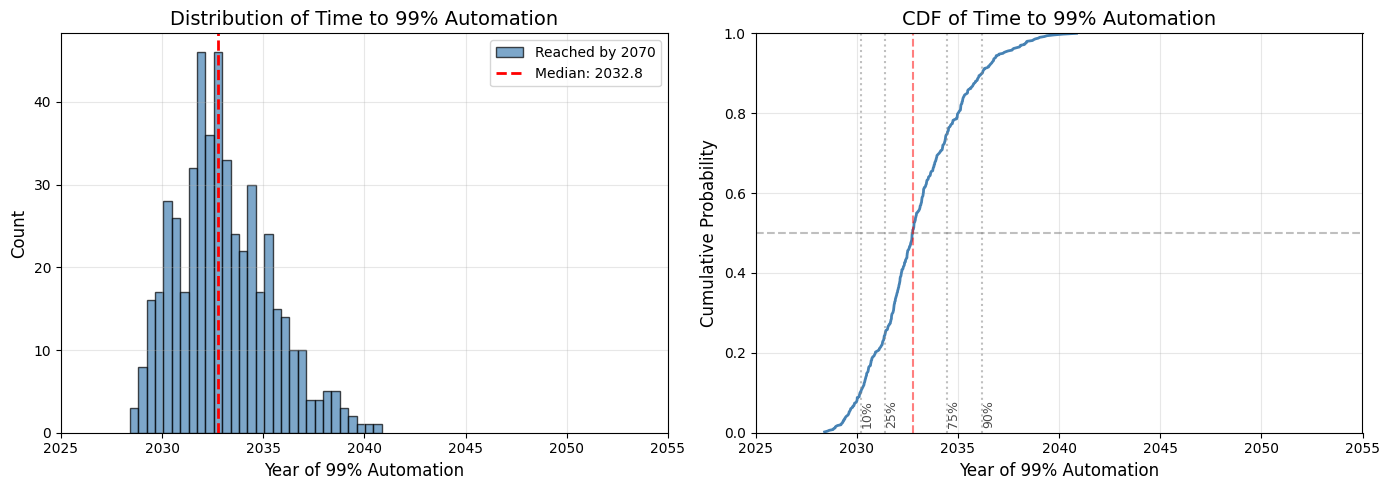


Statistics for time to 99% automation:
  (Trajectories not reaching 99% by 2070 are set to 2100)
  Min: 2028.41
  10th percentile: 2030.20
  25th percentile: 2031.42
  Median: 2032.76
  75th percentile: 2034.48
  90th percentile: 2036.20
  Max: 2040.86
  Fraction reaching 99% by 2070: 100.0%


In [8]:
# Plot distribution of time to 99% automation (including those that don't reach by cutoff)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# All times are now valid (those that didn't reach are set to YEAR_NOT_REACHED)
all_times = times_to_99_large

# Histogram - show the YEAR_NOT_REACHED bar separately
times_before_cutoff = [t for t in all_times if t < YEAR_NOT_REACHED]
times_after_cutoff = [t for t in all_times if t >= YEAR_NOT_REACHED]

ax1.hist(times_before_cutoff, bins=30, edgecolor='black', alpha=0.7, color='steelblue', label=f'Reached by {YEAR_CUTOFF}')
if times_after_cutoff:
    # Add a bar at YEAR_NOT_REACHED for those that didn't reach
    ax1.bar(YEAR_NOT_REACHED, len(times_after_cutoff), width=2, edgecolor='black', alpha=0.7, color='gray', 
            label=f'Not reached by {YEAR_CUTOFF} (n={len(times_after_cutoff)})')

ax1.axvline(np.median(all_times), color='red', linestyle='--', linewidth=2, 
            label=f'Median: {np.median(all_times):.1f}')
ax1.set_xlabel('Year of 99% Automation', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of Time to 99% Automation', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(YEAR_START - 1, YEAR_PLOT_END)

# CDF - includes all trajectories
sorted_times = np.sort(all_times)
cdf = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
ax2.plot(sorted_times, cdf, linewidth=2, color='steelblue')
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(np.median(all_times), color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Year of 99% Automation', fontsize=12)
ax2.set_ylabel('Cumulative Probability', fontsize=12)
ax2.set_title('CDF of Time to 99% Automation', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)
ax2.set_xlim(YEAR_START - 1, YEAR_PLOT_END)

# Add percentiles
for p in [10, 25, 75, 90]:
    pct = np.percentile(all_times, p)
    ax2.axvline(pct, color='gray', linestyle=':', alpha=0.5)
    ax2.text(pct, 0.02, f'{p}%', rotation=90, fontsize=9, alpha=0.7)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nStatistics for time to 99% automation:")
print(f"  (Trajectories not reaching 99% by {YEAR_CUTOFF} are set to {YEAR_NOT_REACHED})")
print(f"  Min: {min(all_times):.2f}")
print(f"  10th percentile: {np.percentile(all_times, 10):.2f}")
print(f"  25th percentile: {np.percentile(all_times, 25):.2f}")
print(f"  Median: {np.median(all_times):.2f}")
print(f"  75th percentile: {np.percentile(all_times, 75):.2f}")
print(f"  90th percentile: {np.percentile(all_times, 90):.2f}")
print(f"  Max: {max(all_times):.2f}")
print(f"  Fraction reaching 99% by {YEAR_CUTOFF}: {len(times_before_cutoff)/len(all_times):.1%}")

## Output 3: Median Time to 99% Automation by Parameter Buckets

In [ ]:
def compute_median_by_buckets(param_values, times_to_99, n_buckets=10):
    """
    Compute median time to 99% in each bucket of parameter values.
    All trajectories are included (those not reaching 99% by cutoff are set to YEAR_NOT_REACHED).
    """
    if len(param_values) < n_buckets:
        return None, None, None
    
    # Create buckets based on percentiles
    percentiles = np.linspace(0, 100, n_buckets + 1)
    bucket_edges = np.percentile(param_values, percentiles)
    
    bucket_centers = []
    bucket_medians = []
    
    for i in range(n_buckets):
        low, high = bucket_edges[i], bucket_edges[i + 1]
        if i == n_buckets - 1:
            mask = [(low <= p <= high) for p in param_values]
        else:
            mask = [(low <= p < high) for p in param_values]
        
        times_in_bucket = [t for t, m in zip(times_to_99, mask) if m]
        params_in_bucket = [p for p, m in zip(param_values, mask) if m]
        
        if len(times_in_bucket) >= 3:  # Need at least 3 for meaningful median
            bucket_centers.append(np.median(params_in_bucket))
            bucket_medians.append(np.median(times_in_bucket))
    
    return bucket_centers, bucket_medians, bucket_edges

# Extract parameter values
betas = [p['beta'] for p in params_large]
one_over_vs = [p['one_over_v'] for p in params_large]
f_2026s = [p['f_2026'] for p in params_large]

# Create figure with subplots for each variable
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

variables = [
    (betas, 'β', 'Beta'),
    (one_over_vs, '1/v', 'Automation slowness'),
    (f_2026s, 'f(2026)', 'Initial automation'),
]

for ax, (values, label, title) in zip(axes.flat, variables):
    centers, medians, edges = compute_median_by_buckets(values, times_to_99_large, n_buckets=10)
    
    if centers is not None:
        ax.plot(centers, medians, 'o-', linewidth=2, markersize=8, color='steelblue')
        ax.set_xlabel(label, fontsize=12)
        ax.set_ylabel('Median year of 99% automation', fontsize=11)
        ax.set_title(f'Conditional on {title}', fontsize=12)
        ax.grid(True, alpha=0.3)
        # Set y-axis to show the full range including YEAR_NOT_REACHED
        ax.set_ylim(min(medians) - 1, max(medians) + 1)
    else:
        ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=ax.transAxes)

fig.suptitle('Sensitivity Analysis', fontsize=16)
plt.tight_layout()
fig.savefig('new_figures/sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved to new_figures/sensitivity.png")
print(f"Note: Trajectories not reaching 99% by {YEAR_CUTOFF} are assigned year {YEAR_NOT_REACHED}")

## Output 4: Interactive Version with Sliders

In [ ]:
def plot_interactive_trajectory(beta, one_over_v, f_2026, t_end=T_END):
    """
    Plot trajectory for given parameters (4-panel + separate automation plot).
    Uses new equation: S' = k / (f^f (1-f)^(1-f)) * L^(1-f) * C^f * S^(1-beta)
    """
    from scipy.special import logit
    
    # Derive parameters
    v = 1.0 / one_over_v
    L_2026 = 1.0
    S_2026 = 1.0
    C_2026 = 1.0
    
    # Compute E_hac from f_2026
    log_E_hac = np.log(C_2026 * S_2026) - logit(f_2026) / v
    E_hac = np.exp(log_E_hac)
    
    # Compute k from growth rate constraint
    dlogS_dt_2026 = np.log(5)  # 5x/year
    dS_dt_2026 = S_2026 * dlogS_dt_2026
    
    prefactor = ff_prefactor(f_2026)
    labor_term = L_2026 ** (1 - f_2026)
    C_term = C_2026 ** f_2026
    S_term = S_2026 ** (1 - beta)
    k = dS_dt_2026 / (prefactor * labor_term * C_term * S_term)
    
    params = {
        'beta': beta,
        'v': v,
        'k': k,
        'L_2026': L_2026,
        'C_2026': C_2026,
        'S_2026': S_2026,
        'E_hac': E_hac,
        'f_2026': f_2026
    }
    
    # Simulate
    t_arr, S_arr, f_arr, R_arr, serial_ratio_arr, parallel_ratio_arr, time_99 = simulate_trajectory(params, t_start=0, t_end=t_end)
    
    if t_arr is None:
        print("Error: Could not integrate trajectory")
        return
    
    # Plot 4 panels
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Top left: S trajectory (log scale)
    axes[0, 0].plot(t_arr + YEAR_START, S_arr, linewidth=2, color='steelblue')
    axes[0, 0].set_xlabel('Year', fontsize=12)
    axes[0, 0].set_ylabel('Software Level S', fontsize=12)
    axes[0, 0].set_yscale('log')
    axes[0, 0].set_title('Software Efficiency', fontsize=14)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlim(YEAR_START, YEAR_PLOT_END)
    
    # Top right: Compute:labor ratio
    axes[0, 1].plot(t_arr + YEAR_START, parallel_ratio_arr, linewidth=2, color='steelblue')
    axes[0, 1].set_xlabel('Year', fontsize=12)
    axes[0, 1].set_ylabel('Compute:Labor Ratio (2026=1)', fontsize=12)
    axes[0, 1].set_yscale('log')
    axes[0, 1].set_title('Compute:Labor Ratio $C^f / L^{1-f}$ (normalized)', fontsize=14)
    axes[0, 1].axhline(1, color='gray', linestyle='--', alpha=0.5)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlim(YEAR_START, YEAR_PLOT_END)
    
    # Bottom left: R(t) research production
    axes[1, 0].plot(t_arr + YEAR_START, R_arr, linewidth=2, color='steelblue')
    axes[1, 0].set_xlabel('Year', fontsize=12)
    axes[1, 0].set_ylabel('Research Production R(t)', fontsize=12)
    axes[1, 0].set_yscale('log')
    axes[1, 0].set_title('Research Production', fontsize=14)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim(YEAR_START, YEAR_PLOT_END)
    
    # Bottom right: Compute:labor ratio
    axes[1, 1].plot(t_arr + YEAR_START, serial_ratio_arr, linewidth=2, color='steelblue')
    axes[1, 1].set_xlabel('Year', fontsize=12)
    axes[1, 1].set_ylabel('Compute:Labor Ratio (2026=1)', fontsize=12)
    axes[1, 1].set_yscale('log')
    axes[1, 1].set_title('Compute:Labor Ratio $C^f / L^{1-f}$ (normalized)', fontsize=14)
    axes[1, 1].axhline(1, color='gray', linestyle='--', alpha=0.5)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlim(YEAR_START, YEAR_PLOT_END)
    
    plt.tight_layout()
    plt.show()
    
    # Separate automation trajectory plot
    fig2, ax_f = plt.subplots(figsize=(10, 5))
    ax_f.plot(t_arr + YEAR_START, f_arr, linewidth=2, color='steelblue')
    ax_f.axhline(0.99, color='red', linestyle='--', linewidth=2, alpha=0.7, label='99% automation')
    if time_99:
        ax_f.axvline(time_99, color='green', linestyle='--', linewidth=2, alpha=0.7, 
                    label=f'99% at {time_99:.2f}')
    ax_f.set_xlabel('Year', fontsize=12)
    ax_f.set_ylabel('Automation fraction f', fontsize=12)
    ax_f.set_title('Automation Trajectory', fontsize=14)
    ax_f.set_yscale('logit')
    ax_f.set_ylim(0.1, 0.999)
    ax_f.axhline(0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    ax_f.axhline(0.9, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    ax_f.axhline(0.98, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    ax_f.legend(fontsize=11)
    ax_f.grid(True, alpha=0.3)
    ax_f.set_xlim(YEAR_START, YEAR_PLOT_END)
    plt.tight_layout()
    plt.show()
    
    # Print info
    print(f"Derived parameters:")
    print(f"  β = {beta:.3f}")
    print(f"  1/v = {one_over_v:.3f} (v = {v:.3f})")
    print(f"  f(2026) = {f_2026:.3f}")
    print(f"  E_hac = {E_hac:.4f}")
    print(f"  k = {k:.4f}")
    print(f"\nTime to 99% automation: {time_99:.2f}" if time_99 else "\nDid not reach 99% automation within simulation window")

# Create interactive widget
interact(
    plot_interactive_trajectory,
    beta=FloatSlider(min=0.3, max=1.0, step=0.01, value=0.65, 
                     description='β:', continuous_update=False,
                     style={'description_width': '80px'}),
    one_over_v=FloatSlider(min=1.5, max=4.2, step=0.05, value=2.85, 
                           description='1/v:', continuous_update=False,
                           style={'description_width': '80px'}),
    f_2026=FloatSlider(min=0.25, max=0.5, step=0.01, value=0.375, 
                       description='f(2026):', continuous_update=False,
                       style={'description_width': '80px'}),
    t_end=fixed(T_END)
);

## Key Observations

The model exhibits interesting dynamics:

1. **Feedback loop**: As S increases, f increases (more automation), which shifts the Cobb-Douglas exponents from labor toward compute, accelerating S growth further.

2. **Dynamic factor shares**: The exponents $1-f$ on labor and $f$ on compute mean that as automation increases, compute matters more and labor matters less. The prefactor $1/(f^f(1-f)^{1-f})$ ensures the function remains well-behaved.

3. **Parameter sensitivity**: 
   - Higher v (faster automation) leads to earlier 99% automation
   - Lower β (easier software improvement) accelerates takeoff
   - Higher initial f (starting automation) means less runway before high automation

4. **Compute plateau**: The flattening of compute growth after 2029 slows trajectories that haven't reached high automation by then.

5. **Uncertainty**: The triangular parameter distributions lead to substantial uncertainty in timing, with wide spreads in the distribution of 99% automation times.